Dimensions du dataset : (2000, 21)

Aperçu des données :
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8   

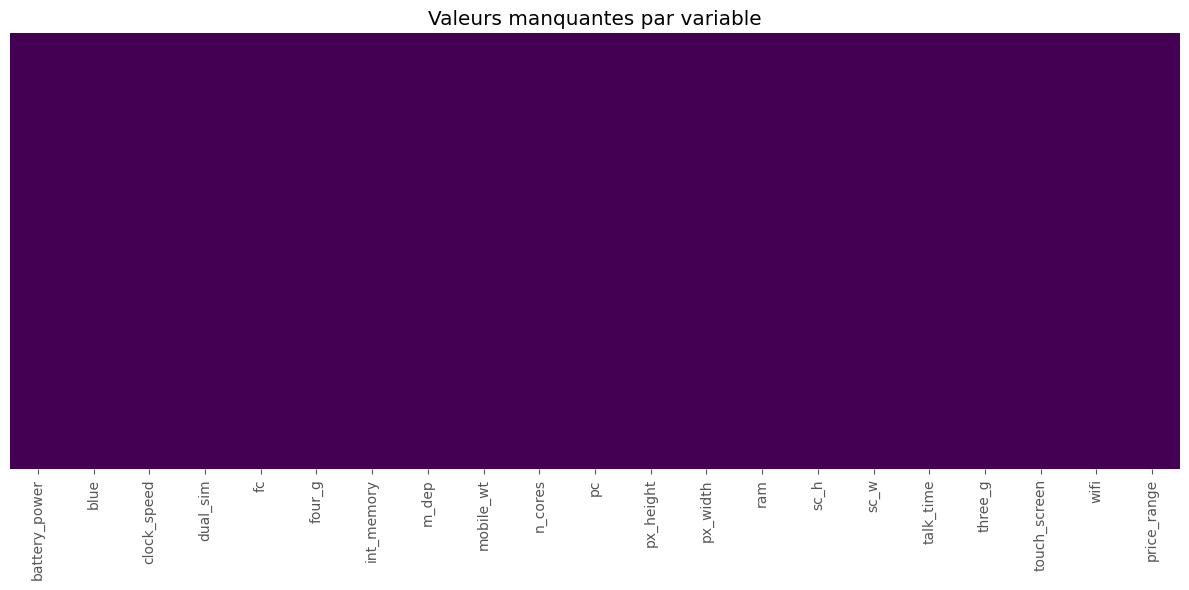


Total des valeurs manquantes par colonne :
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


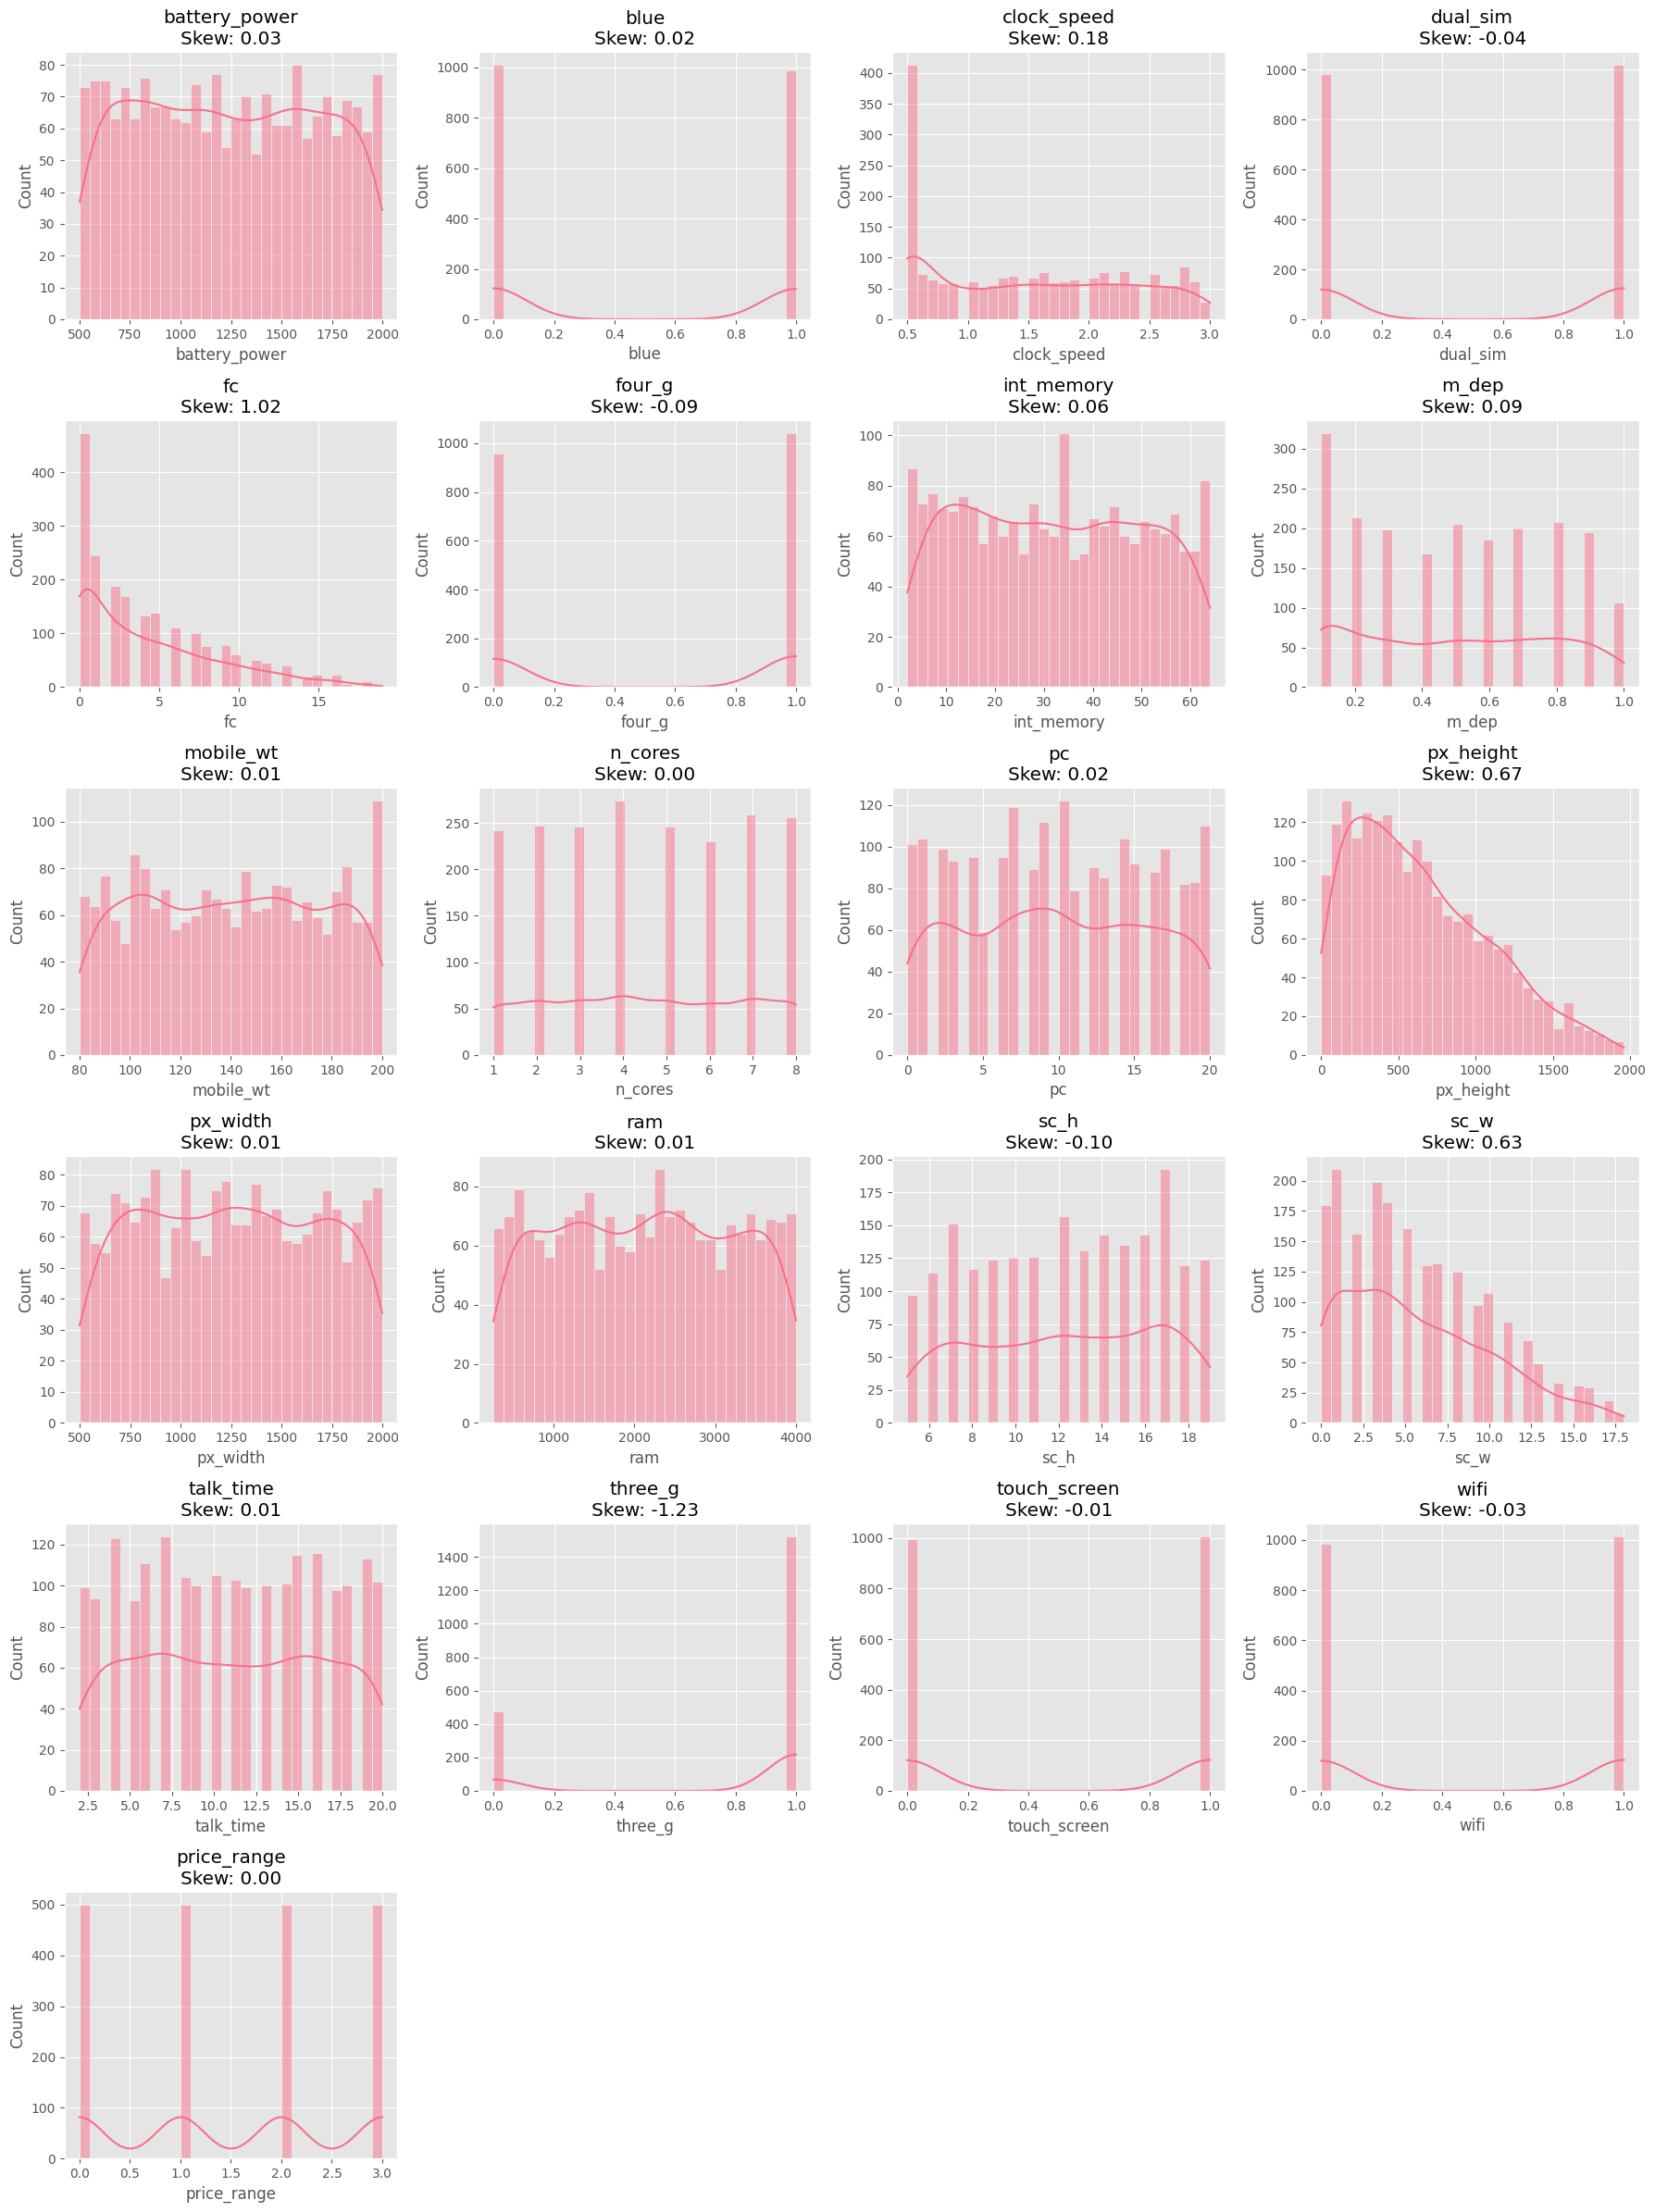

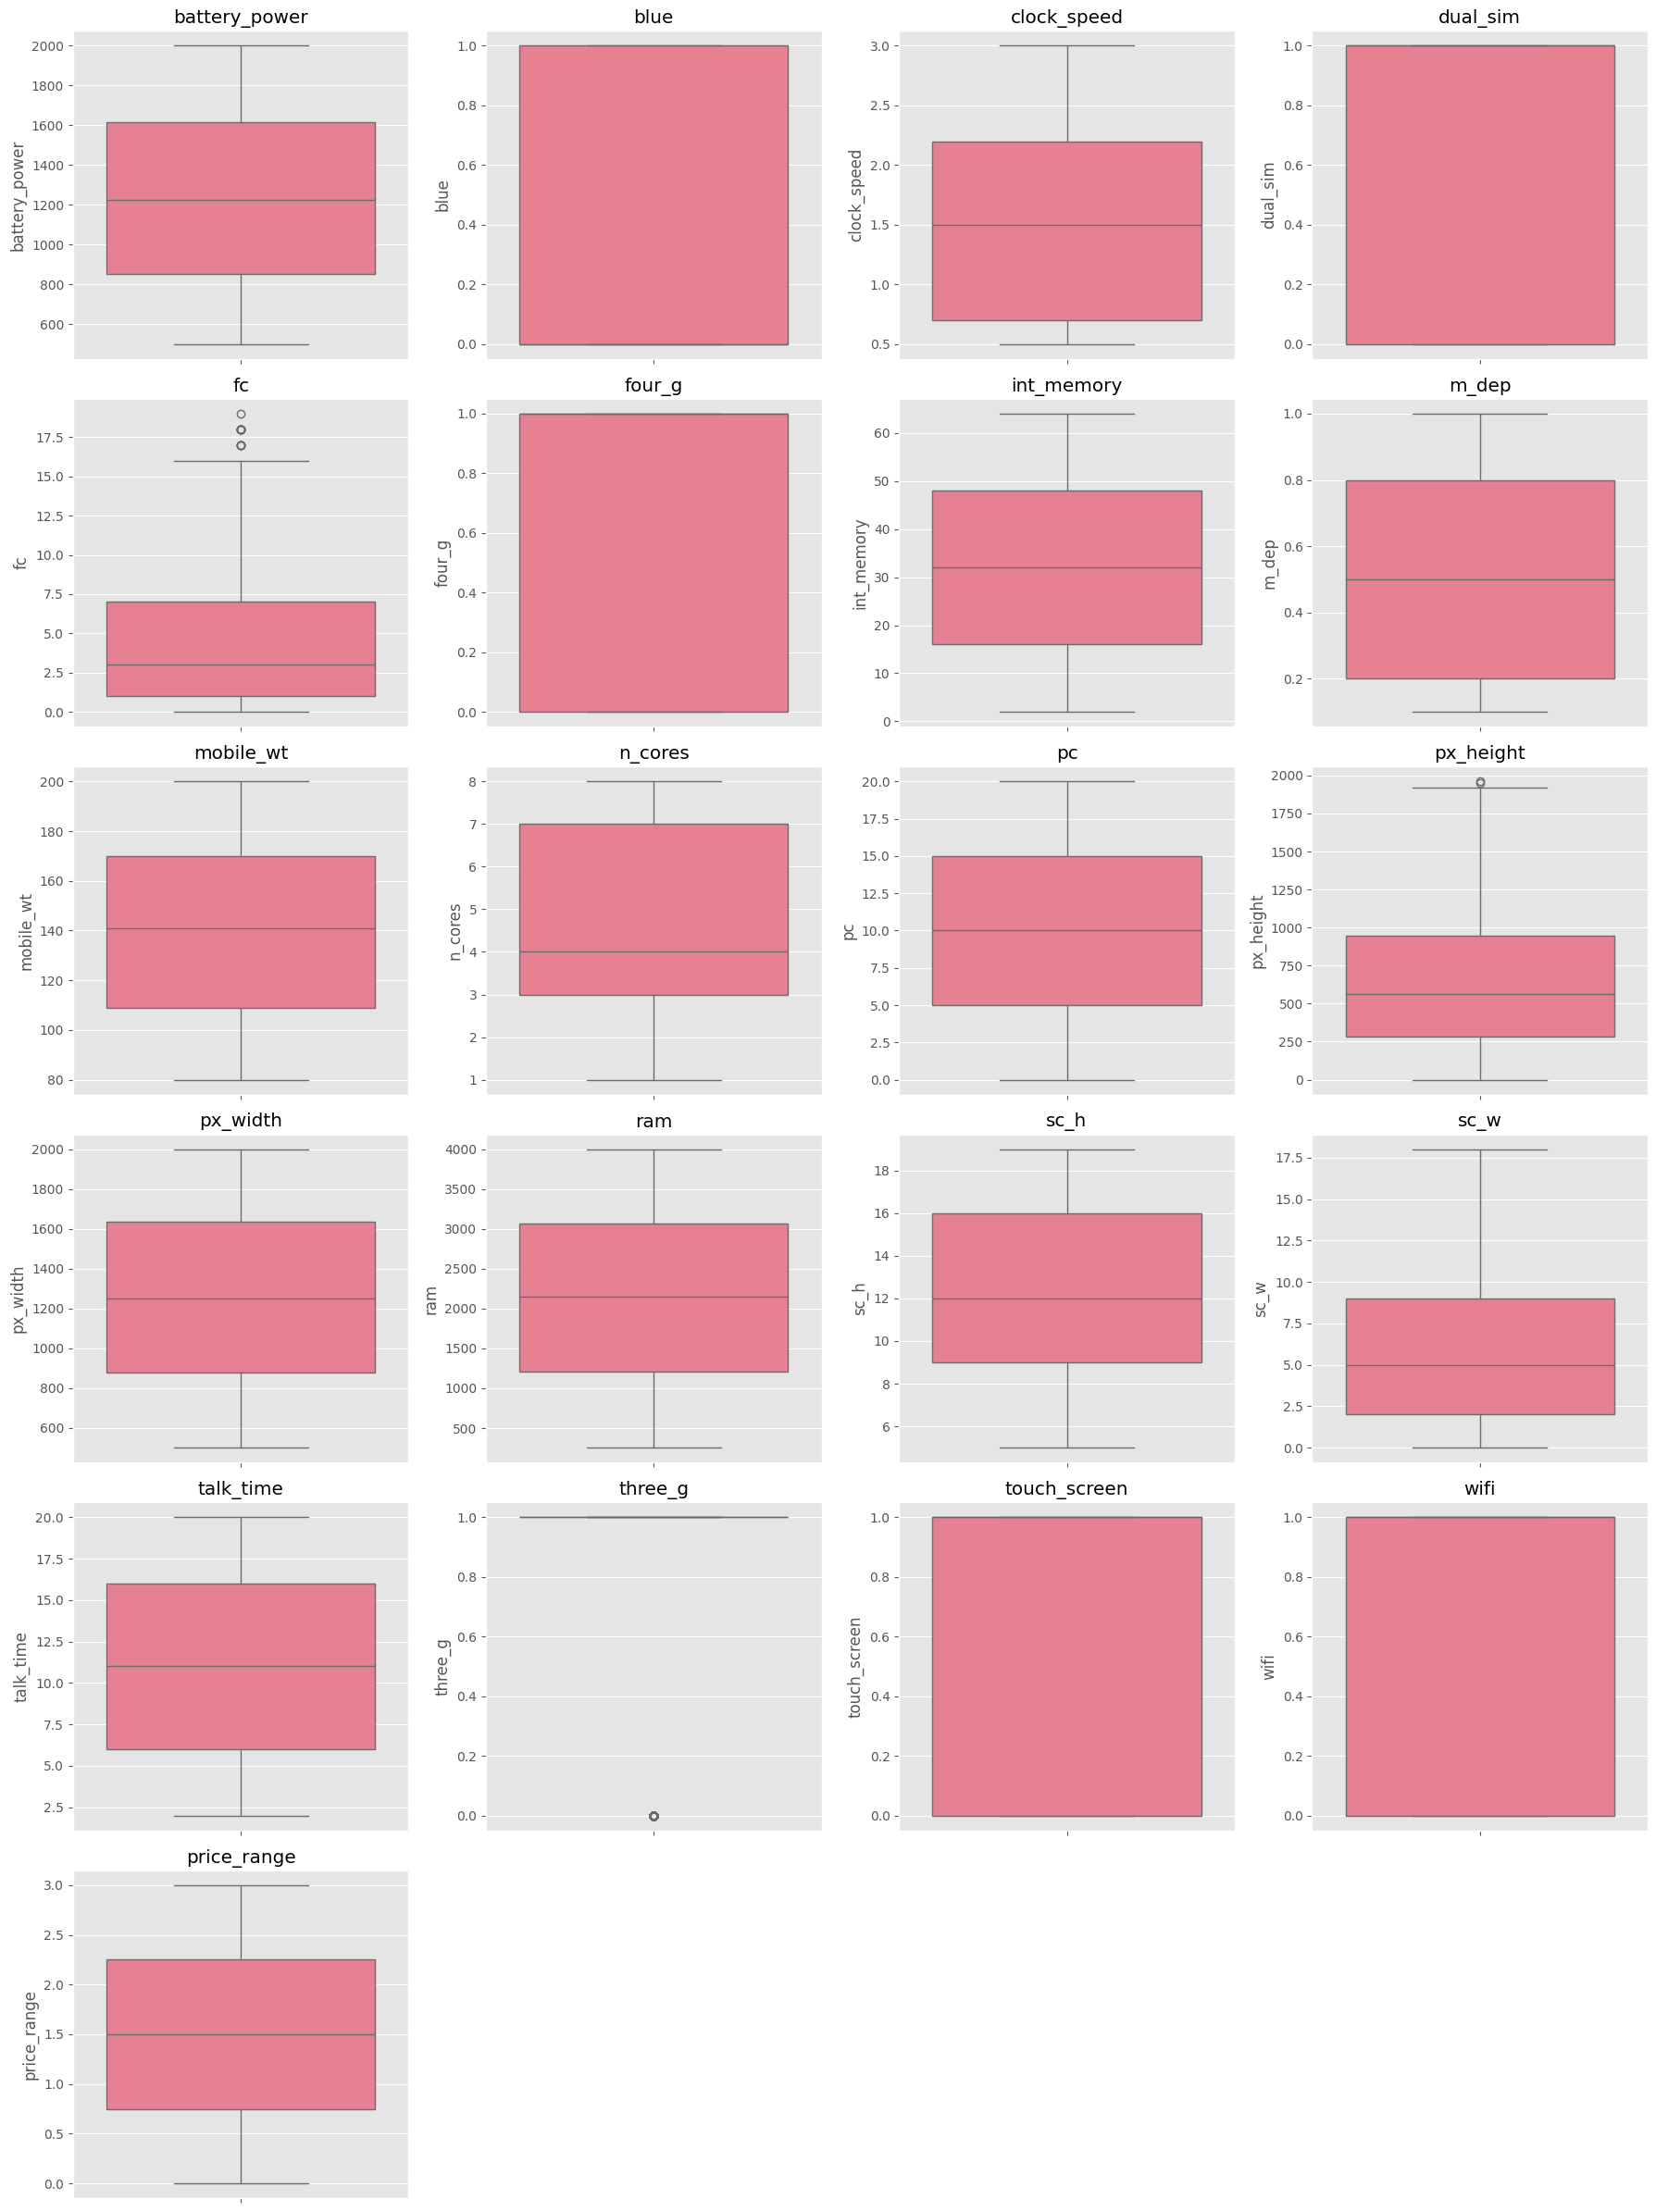

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

# Configuration des styles
plt.style.use('ggplot')
sns.set_palette("husl")

# Chargement des données
df = pd.read_csv('train.csv')

# Affichage des premières lignes
print("Dimensions du dataset :", df.shape)
print("\nAperçu des données :")
print(df.head())

# Informations générales sur les données
print("\nInformations sur les données :")
print(df.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe().T)

# Vérification des valeurs manquantes
def visualiser_valeurs_manquantes(df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Valeurs manquantes par variable')
    plt.tight_layout()
    plt.show()
    
    print("\nTotal des valeurs manquantes par colonne :")
    print(df.isnull().sum())

visualiser_valeurs_manquantes(df)

# Analyse des distributions
def analyser_distributions(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Configuration dynamique
    n_cols = 4
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(18, 4*n_rows))
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'{col}\nSkew: {df[col].skew():.2f}')
    
    plt.tight_layout()
    plt.show()

analyser_distributions(df)

# Détection des outliers
def detecter_outliers(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Configuration dynamique
    n_cols = 4
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(18, 4*n_rows))
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(y=df[col])
        plt.title(col)
    
    plt.tight_layout()
    plt.show()

detecter_outliers(df)

# Traitement des outliers (version améliorée)
def traiter_outliers(df, cols=None, method='winsorize'):
    """
    Traite les outliers selon différentes méthodes
    Args:
        df: DataFrame
        cols: Liste des colonnes à traiter (si None, traite toutes les numériques)
        method: 'winsorize' (par défaut) ou 'clip'
    """
    if cols is None:
        cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    for col in cols:
        if method == 'winsorize':
            q1 = df[col].quantile(0.05)
            q3 = df[col].quantile(0.95)
            df[col] = df[col].clip(lower=q1, upper=q3)
        elif method == 'clip':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

# Traitement spécifique pour px_height et px_width comme dans votre code original
df = traiter_outliers(df, cols=['px_height', 'px_width'], method='clip')

# Préparation des données pour le modèle
def preparer_donnees(df, target_col):
    # Gestion des valeurs manquantes
    df.fillna(df.median(), inplace=True)
    
    # Séparation features/target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Sélection des caractéristiques numériques
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X = X[num_cols]
    
    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

# Exemple d'utilisation (à adapter selon votre cible)
# X, y = preparer_donnees(df, 'target_column')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Analyse PCA (exemple)
def analyser_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
    plt.xlabel('Première Composante Principale')
    plt.ylabel('Deuxième Composante Principale')
    plt.title('Analyse en Composantes Principales')
    plt.show()
    
    print(f"Variance expliquée : {pca.explained_variance_ratio_}")

# Exemple d'utilisation
# analyser_pca(X_scaled)

# ## 3. Analyse des Corrélations

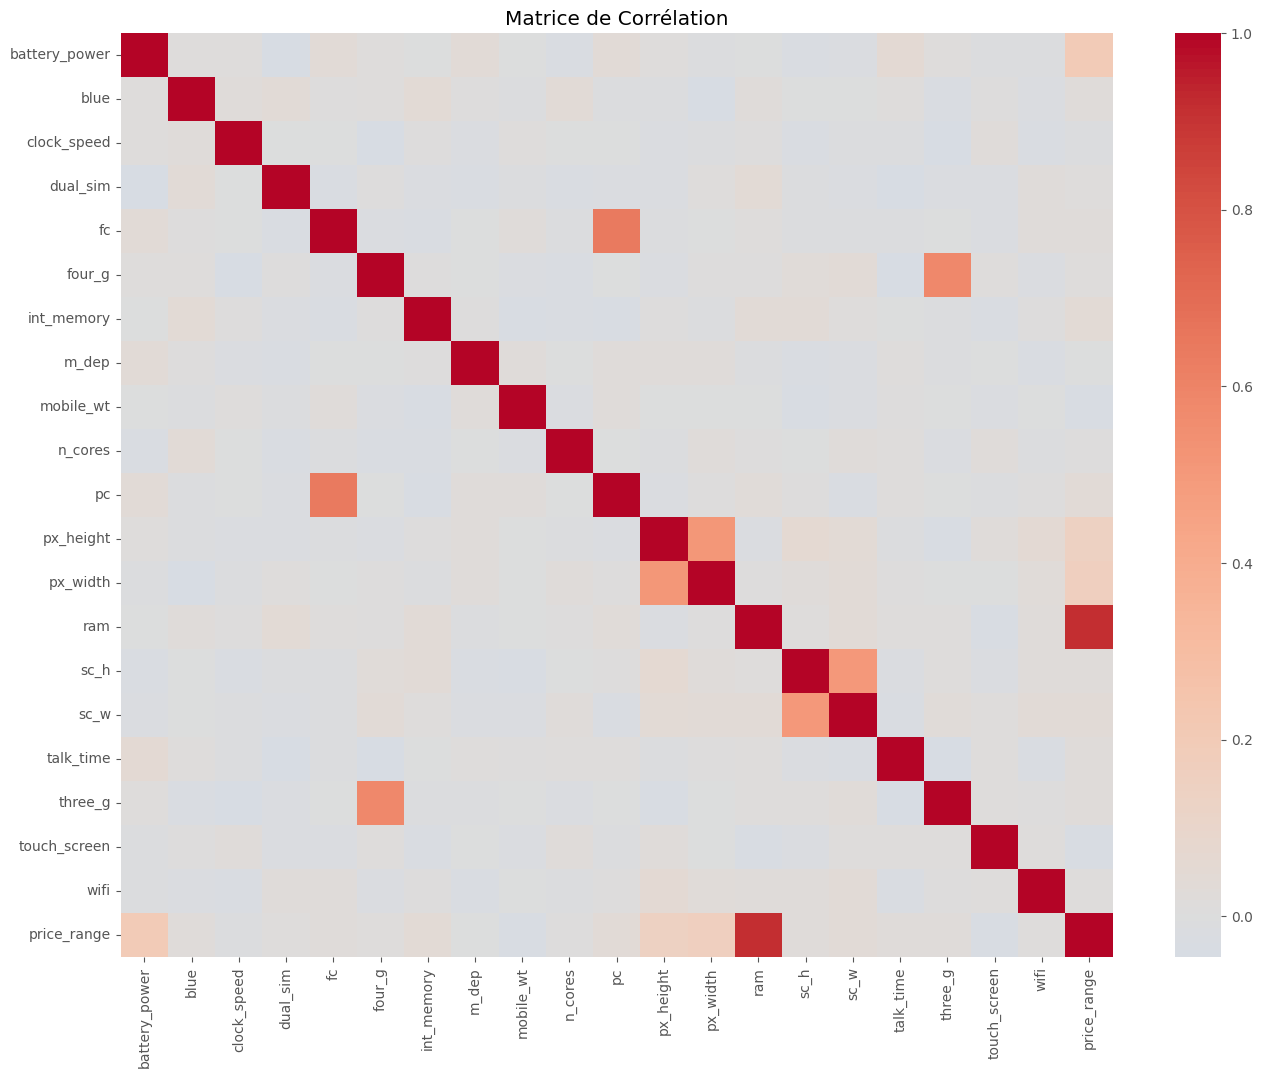

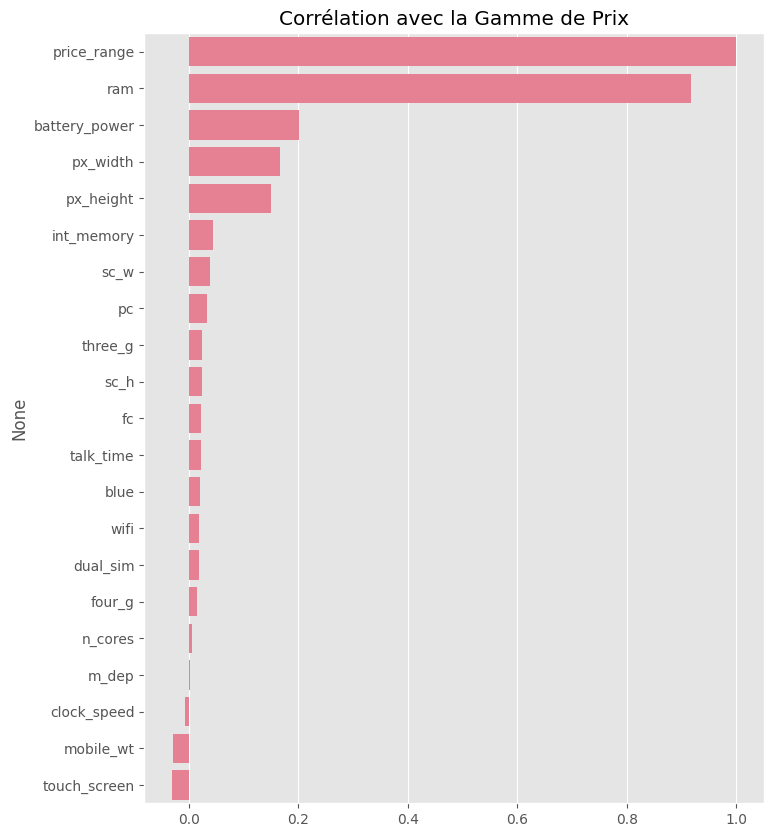

In [2]:
# Matrice de corrélation
plt.figure(figsize=(16, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Matrice de Corrélation')
plt.show()

# Corrélations avec la variable cible
plt.figure(figsize=(8, 10))
corr_with_target = corr_matrix['price_range'].sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Corrélation avec la Gamme de Prix')
plt.show()

# ## 4. Analyse par Gamme de Prix

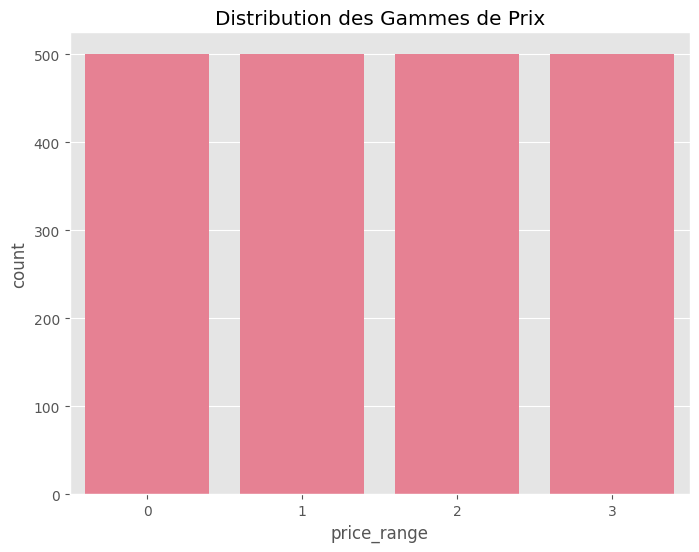

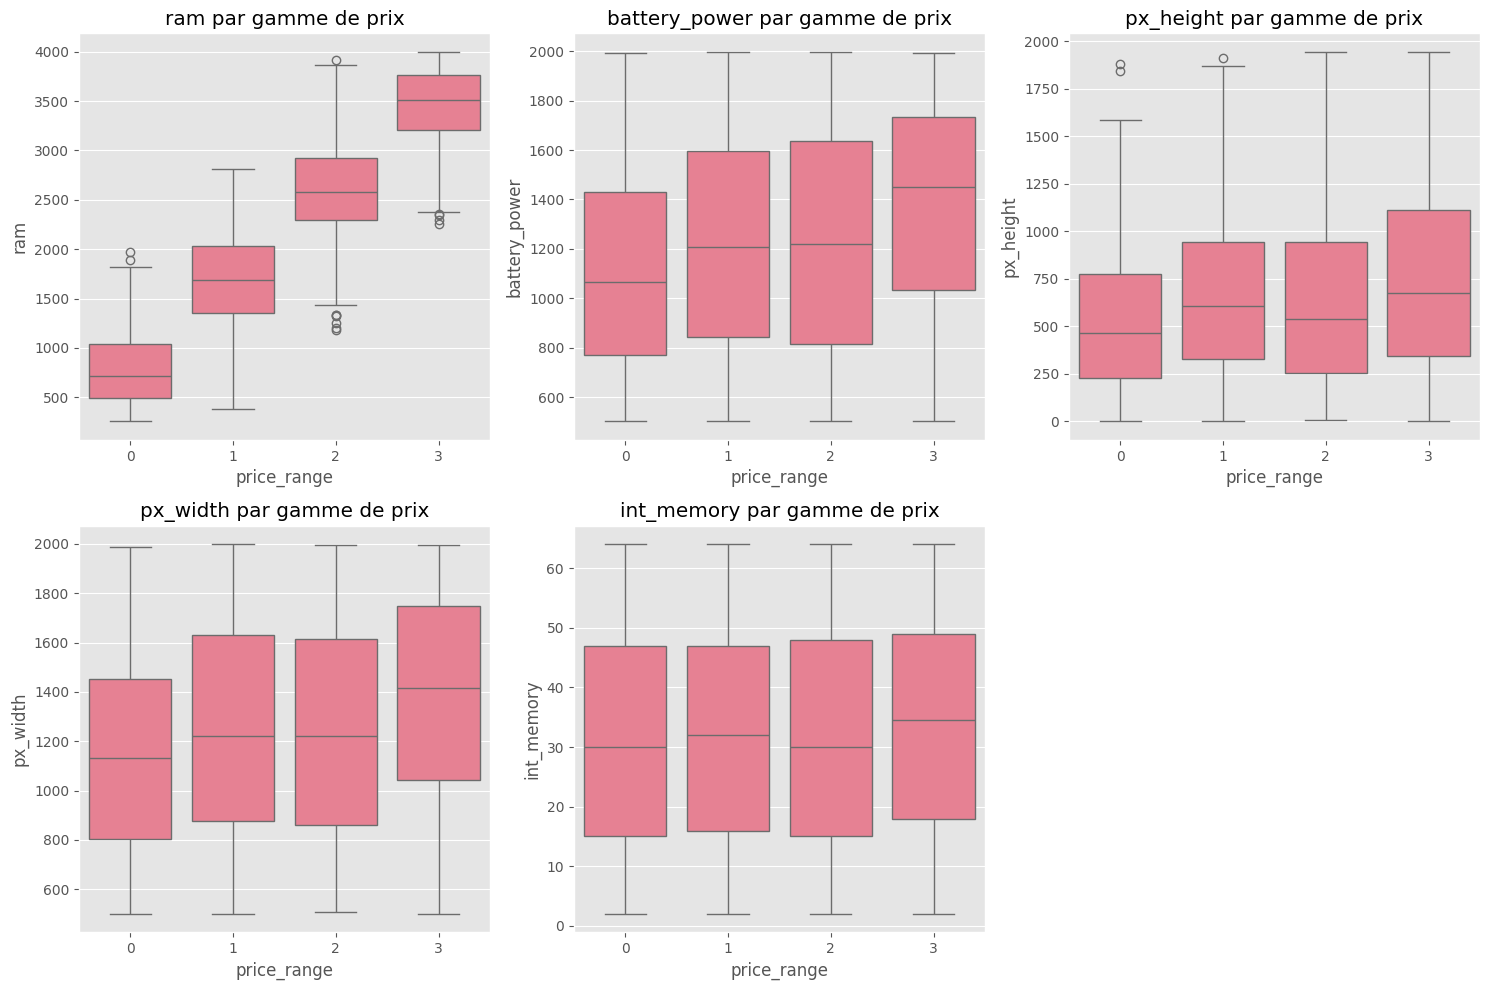

In [3]:

# Distribution de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='price_range', data=df)
plt.title('Distribution des Gammes de Prix')
plt.show()

# Analyse des caractéristiques par gamme de prix
features_to_analyze = ['ram', 'battery_power', 'px_height', 'px_width', 'int_memory']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_analyze):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='price_range', y=feature, data=df)
    plt.title(f'{feature} par gamme de prix')
plt.tight_layout()
plt.show()

 ## 5. Réduction de Dimension et Visualisation

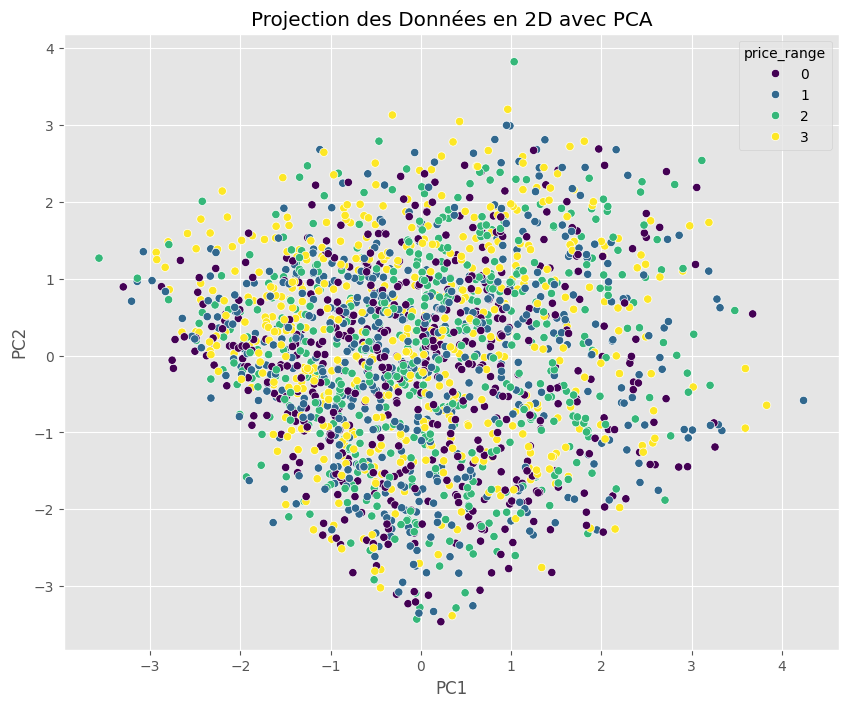

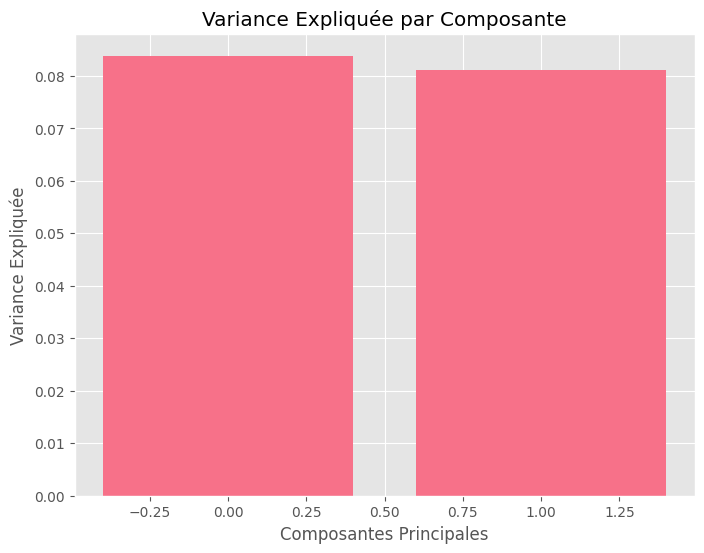

In [4]:
# Préparation des données pour PCA
X = df.drop('price_range', axis=1)
y = df['price_range']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# %%
# Analyse en Composantes Principales
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['price_range'] = y

# %%
# Visualisation PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='price_range', data=pca_df, palette='viridis')
plt.title('Projection des Données en 2D avec PCA')
plt.show()

# %%
# Variance expliquée
plt.figure(figsize=(8, 6))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Composantes Principales')
plt.ylabel('Variance Expliquée')
plt.title('Variance Expliquée par Composante')
plt.show()

Conclusions principales :

- La RAM est de loin la caractéristique la plus importante pour déterminer la gamme de prix
- La résolution d'écran et la capacité de la batterie sont également très importantes
- Les téléphones sont bien séparés en groupes selon leurs caractéristiques techniques

Recommandations :
- Pour positionner un téléphone dans une gamme de prix supérieure, augmenter la RAM et la résolution d'écran
- Les caractéristiques comme le Bluetooth ou le double SIM ont moins d'impact sur le prix